In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import traceback
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
def check_old_naming(animalid, session, fov, experiment='blobs', traceid='traces001',
                decode_type='single_cells', sub_dir='dff-nstds_stimulus', C_str='tuneC',
                rootdir='/n/coxfs01/2p-data'):
    
    res_files = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', decode_type, sub_dir, '*%s*.pkl' % C_str))
    for r in res_files:
        curr_dir, fname = os.path.split(r)
        if fname.startswith('single_cells_'):
            new_name = fname.split('single_cells_')[-1]
            os.rename(r, os.path.join(curr_dir, new_name))
    return


In [4]:
def plot_true_and_shuffled_distns(meandf, metric='heldout_test_score', return_scores=True, ax=None):
    '''
    Takes 
    '''
    
    tru_df = meandf[meandf['condition']=='data']
    shu_df = meandf[meandf['condition']=='shuffled']

    mean_score = tru_df[metric].mean()
    shuffled_score = shu_df[metric].mean()
    score_percentile = np.mean(mean_score < shu_df[metric])
    #print('%.2f, %.2f' % (mean_score, shuffled_score))

    # PLOT
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(tru_df[metric], ax=ax, color='m')
    sns.distplot(shu_df[metric], ax=ax, color='k')
    ax.axvline(x=mean_score, linestyle=':', color='m')
    ax.axvline(x=shuffled_score, linestyle=':', color='k')
    
    if return_scores:
        return ax, mean_score, score_percentile
    else:
        return ax
    
    

In [5]:
def stripplot_by_area(metric, data_df, ax=None, area_colors=None, size=5,
                     visual_areas=['V1', 'Lm', 'Li', 'Ll'], scale=2, bar=True, annotate=True, xytext=(0, -10)):
    if ax is None:
        fig, ax = pl.subplots()
        
    if area_colors is None:
        cols = sns.color_palette('colorblind', n_colors=len(visual_areas))
        area_colors = dict((v, c) for v, c in zip(visual_areas, cols))    
    
    if bar or annotate:
        sns.barplot(x='visual_area',  y=metric, data=data_df, ax=ax,
                           order=visual_areas,
                           zorder=0, edgecolor='none', facecolor='none', color='none')
        data_df.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=xytext)
        
    sns.stripplot(x='visual_area',  y=metric, data=data_df, ax=ax,
               order=visual_areas, hue='visual_area',
               zorder=1, size=2, palette=area_colors)

    sns.pointplot(x='visual_area',  y=metric, data=data_df, ax=ax, join=False,
               order=visual_areas, markers='_', color='k', # palette=area_colors,
               scale=1, zorder=1000)
    
    return ax


In [6]:
def get_single_cell_files(animalid, session, fovnum, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None, 
                               test_type=None,
                               verbose=False, rootdir='/n/coxfs01/2p-data'):
    # Get results ID (data identifier)
    result_id = dc.create_results_id(prefix='single_cells',
                            visual_area=visual_area, C_value=C_value, 
                            response_type=response_type, responsive_test=responsive_test, 
                            trial_epoch=trial_epoch, test_type=test_type)
    
    curr_datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    traceid_dir = dc.get_traceid_dir_from_datakey(curr_datakey, traceid=traceid)
    
    src_dir, save_prefix = dc.single_cell_dst_dir(traceid_dir, result_id)
        
    if src_dir is None:
        print("%s - Missing: (%s_%s_%s) %s" % (visual_area, session, animalid, fov, result_id))
        return None, None, None
        
    varea, c_str = save_prefix.split('_') #'tuneC' if C_value is None else 'C%.2f' % C_value
      
    # FInd all results files
    result_fpaths=[]
    missing_fpaths=[]
    if roi_list is None and visual_area is None:
        result_fpaths = glob.glob(os.path.join(src_dir, '*%s*.pkl' % c_str))
    else:
        if roi_list is None:
            result_fpaths =  glob.glob(os.path.join(src_dir, '%s*.pkl' % (save_prefix)))
        else:
            tmp_fns = [os.path.join(src_dir, '%s__%03d.pkl' % (save_prefix, int(rid+1))) \
                                         for rid in roi_list]
            for c in tmp_fns:
                if not os.path.exists(c):
                    missing_fpaths.append(c)
                else:
                    result_fpaths.append(c)
                    
    if verbose:
        print("(%s, %s) Found %i. Missing %i." % (session, animalid, len(result_fpaths), len(missing_fpaths)))
    
    return result_fpaths, missing_fpaths, result_id

    
            
def load_cell_results_from_fov(animalid, session, fovnum, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None,
                               test_type=None,
                               rootdir='/n/coxfs01/2p-data', verbose=False):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    missing_rois=None
    result_id=None
    
    result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, 
                                roi_list=roi_list, verbose=verbose, test_type=test_type)
    
    if result_fns is None:
        return None, None, None
    
    if roi_list is not None:
        missing_rois = [int(os.path.splitext(os.path.split(f)[-1])[0].split('_')[-1])-1 for f in missing_fns]
        
    rlist=[]
    for c in result_fns:
        with open(c, 'rb') as f:
            res = pkl.load(f)
        res['iteration'] = res.index.tolist()
        res = res.reset_index(drop=True).sort_values(by='iteration')
        rlist.append(res)
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=0).reset_index(drop=True)
    
#     if (roi_list is not None) and (roidf is not None):
#         missing_rois = [r for r in roi_list if r not in roidf['cell'].unique()]
        
    return roidf, missing_rois, result_id


#### Test single-cell results loading

In [7]:
animalid = 'JC084'
session='20190522'
fovnum = 1

datakey='%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='V1'

g = CELLS[(CELLS.visual_area==visual_area) & (CELLS.datakey==datakey)]
result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, 
                                roi_list=g['cell'].unique(), verbose=False, test_type=test_type)
print(len(result_fns))
print("missing: %i" % len(missing_fns))

NameError: name 'CELLS' is not defined

In [39]:
len(result_fns)

52

In [41]:
len(missing_fns)

55

In [42]:
g.shape

(107, 9)

# Dataset info

In [8]:
analysis_type='single_cells'
n_iterations=100

overlap_thr=None #0.5
n_processes=1
responsive_test='ROC'
experiment='blobs'
C_value=None

has_rfs = overlap_thr is not None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set responsivitiy params
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = 10.0 if responsive_test=='nstds' else 0.05 #float(opts.responsive_thr) #10
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

# Create data ID for labeling figures with data-types
stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)

# Choose what type classifier to make
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr is None else float(opts.overlap_thr) 

# Set classifier training params
C_value = opts.C_value
do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")


traces001|filter_None_blobsonly|dff_ROC-thr-0.05
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None
............................................
Responsive test: ROC (thr=0.05)
............................................


In [9]:
train_str = 'by_singlecells_iter-%i' % (n_iterations)

# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)

dpi = putils.set_plot_params()

# Output dir

In [10]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', 'single_cells')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells


# Get metadata for experiment type

In [10]:
# #### Get metadata for experiment type
# sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)

# # sdata_exp = sdata[sdata['experiment']==experiment]
# #sdata_exp['visual_area'].unique()

# edata, expmeta = aggr.experiment_datakeys(experiment='blobs', has_rfs=has_rfs, 
#                             has_gratings=has_gratings, stim_filterby=None,
#                                 experiment_only=False)
# print(edata['visual_area'].unique())

Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
[u'V1' u'Ll' u'Lm' u'Li']


In [11]:
#### Load neural responses
responsive_test='ROC' #'roc'
responsive_thr=10.0 if responsive_test=='nstds' else 0.05
trial_epoch= 'plushalf' #'stimulus'
response_type='dff'

print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

#### Check for equal trial counts
sdata, all_cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, 
                                       response_type=response_type,
                                       responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, 
                                       trial_epoch=trial_epoch, check_configs=True, 
                                       zscore_now=True, return_configs=True, images_only=False) 
visual_areas = ['V1', 'Lm', 'Li'] #, 'Ll']
all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
sdf_master = aggr.get_master_sdf(images_only=True)

all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,585,585,585,585,585,585,585
Lm,1127,1127,1127,1127,1127,1127,1127
V1,1251,1251,1251,1251,1251,1251,1251


In [17]:
##### Get global cells
remove_too_few=False
min_ncells=5

overlap_thr=None
has_retino=False
threshold_dff=False
match_distns = False

stack_neuraldf = analysis_type=='by_ncells'

has_rfs = (has_retino is False) and (overlap_thr is not None)
print('retino:', has_retino, 'rfs:', has_rfs)
match_str = 'match-Li-distn' if match_distns else ''

results_prefix = analysis_type #set_results_prefix(analysis_type=analysis_type)
if threshold_dff:
    overlap_str='threshdff'
else:
    if has_retino:
        overlap_str = 'retino'
    else:
        overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                                threshold_snr=False, remove_too_few=remove_too_few) 
                                
print("------------------------------------")
print("Final cell counts:")
print(CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())


('retino:', False, 'rfs:', False)
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
             datakey  cell
visual_area               
Li               585   585
Lm              1127  1127
V1              1251  1251


# Decode

In [15]:
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


In [ ]:
# Load single_cells pass

In [ ]:
percentiles = dc.load_single_cells_pass(responsive_test=responsive_test)
percentiles.groupby(['visual_area']).count()['cell']

In [ ]:
p_thr=0.1
# Filter
#excl=['20190314_JC070_fov1', '20190327_JC073_fov1'] if analysis_type=='by_ncells' else []
excl=[]
pass_single = score_percentiles[(percentiles['percentile']<=p_thr)
                               & ~(percentiles['datakey'].isin(excl))].copy()
pass_single['mean_score'] = pass_single['mean_score'].astype(float)
pass_single.groupby(['visual_area']).count()['cell']

In [19]:
trial_epoch

'plushalf'

# Aggregate all single cell results

In [186]:
#### Setup output dirs
test_type='size_subset'
results_id = dc.create_results_id(prefix=results_prefix,
                        visual_area=None, C_value=C_value, trial_epoch=trial_epoch, 
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, has_retino=has_retino, threshold_dff=threshold_dff,
                        test_type=test_type)

print(results_id)

single_cells_None__dff-ROC_noRF__plushalf__tuneC__size_subset


In [187]:
missing_files = dict((k, dict()) for k in visual_areas)
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g \
        in CELLS.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
        
    cell_lut={}
    roidf=None; missing=None; tmpid=None;
    try: 
        roidf, missing, tmpid = load_cell_results_from_fov(animalid, session, 
                             fovnum, experiment, C_value=C_value, trial_epoch=trial_epoch,
                             response_type=response_type, responsive_test=responsive_test,
                             visual_area=visual_area, roi_list=g['cell'].values, verbose=False,test_type=test_type)
    except Exception as e:
        print("ERROR: %s, %s" %(visual_area, datakey))
        traceback.print_exc()
        
        
    if missing is not None and len(missing)>0:
        missing_files[visual_area][datakey] = np.array(missing)
        
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    
    n_expected = len(g['cell'].unique()) 
    n_found = len(roidf['cell'].unique())
    if n_expected != n_found:
        print('Unequal (%s, %s) - Missing %i' % (visual_area, datakey, n_expected-n_found))

    if 'global_ix' in g.columns:
        cell_lut = dict((k,v) for k, v in zip(g['cell'].values, g['global_ix'].values))
        roidf['global_ix'] = [cell_lut[c] for c in roidf['cell'].values]
    else:
        print("(%s, %s) - no global" % (visual_area, datakey))

    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)

singledf = pd.concat(r_list, axis=0)

Unequal (Li, 20190319_JC067_fov1) - Missing 2
Unequal (Li, 20190314_JC070_fov1) - Missing 1
Unequal (Li, 20190316_JC070_fov1) - Missing 6
Unequal (Li, 20190322_JC073_fov1) - Missing 2
Unequal (Li, 20190327_JC073_fov1) - Missing 6
Unequal (Li, 20190422_JC076_fov1) - Missing 26
Unequal (Li, 20190602_JC091_fov1) - Missing 82
[Li] 20190606_JC091_fov1 - No cells.
Unequal (Li, 20190614_JC091_fov1) - Missing 42
Unequal (Li, 20190609_JC099_fov1) - Missing 29
Unequal (Li, 20190612_JC099_fov1) - Missing 33
[Li] 20191018_JC113_fov1 - No cells.
Unequal (Li, 20191111_JC120_fov1) - Missing 13
Unequal (Lm, 20190306_JC061_fov3) - Missing 9
Unequal (Lm, 20190322_JC073_fov1) - Missing 9
Unequal (Lm, 20190327_JC073_fov1) - Missing 2
Unequal (Lm, 20190430_JC078_fov1) - Missing 74
Unequal (Lm, 20190504_JC078_fov1) - Missing 24
Unequal (Lm, 20190509_JC078_fov1) - Missing 43
Unequal (Lm, 20190513_JC078_fov1) - Missing 50
Unequal (Lm, 20190506_JC080_fov1) - Missing 139
Unequal (Lm, 20190603_JC080_fov1) - Miss

In [188]:
 # singledf.groupby(['condition', 'train_transform', 'test_transform']).mean()

In [189]:
all_sizes = sorted(mdf[mdf.novel]['test_transform'].astype(int))
train_labels = ['x(%i)' % int([s for s in all_sizes if s not in [int(i) for i in tlabel.split('_')]][0]) \
                 for tlabel in mdf['train_transform'].unique()]
train_labels

['x(50)', 'x(40)', 'x(30)', 'x(20)', 'x(10)']

<IPython.core.display.Javascript object>


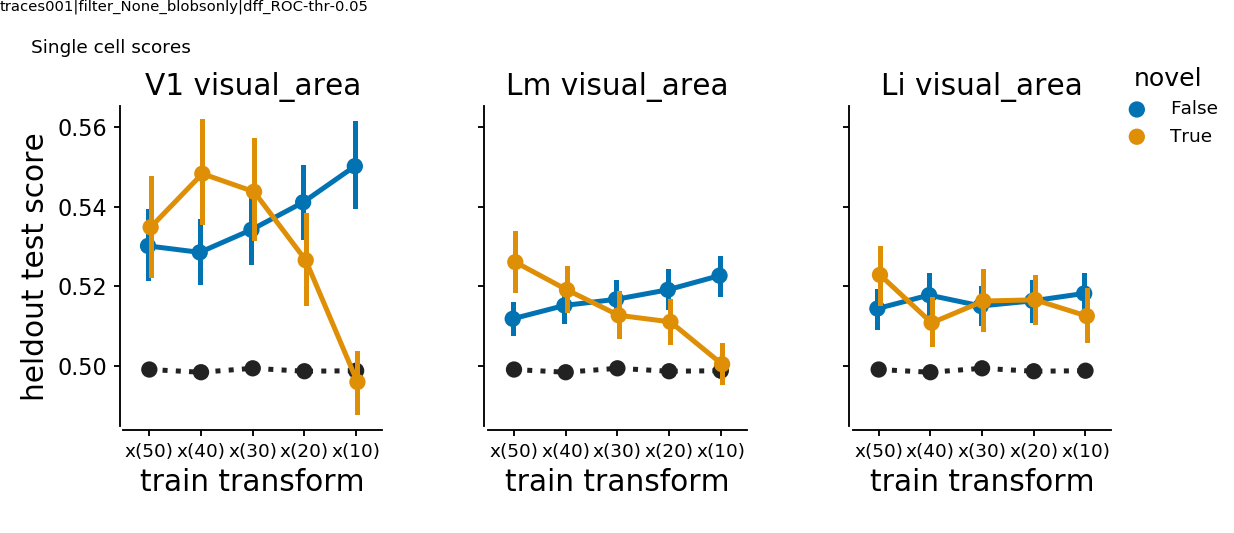

Text(0.025,0.9,u'Single cell scores')

In [190]:

metric_label='heldout test score'
mdf = singledf.groupby(['visual_area', 'datakey', 'cell', 'condition', 'train_transform', 'test_transform']).mean().reset_index()


g = sns.catplot(x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='data'], 
            hue='novel', palette='colorblind', dodge=True, kind='point', 
            col='visual_area', col_order=visual_areas, height=4, aspect=0.7, legend_out=True)

g.map(sns.pointplot, x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='shuffled'],
      hue='novel', linestyles=':', legend_out=True)

(g.set_axis_labels("train transform", metric_label)\
     .set_titles("{col_name} {col_var}")\
     .despine(offset=2)\
#      .set(ylim=(0.4, 0.6))\
     .set_xticklabels(train_labels, fontsize=10))

pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.9)
g._legend.set(bbox_to_anchor=(1., 0.8))

putils.label_figure(g.fig, data_id)
g.fig.text(0.025, 0.9, 'Single cell scores')


In [191]:
# pp.pprint(dict((k, v.keys()) for k, v in missing_files.items()))
for v, vdict in missing_files.items():
    for d, dlist in vdict.items():
        print('[%s] %s (missing %i)' % (v, d, len(dlist)))

[V1] 20190511_JC083_fov1 (missing 78)
[V1] 20190613_JC097_fov1 (missing 119)
[V1] 20190509_JC078_fov1 (missing 3)
[V1] 20190512_JC083_fov1 (missing 18)
[V1] 20190522_JC084_fov1 (missing 105)
[V1] 20190622_JC085_fov1 (missing 188)
[V1] 20190501_JC076_fov1 (missing 18)
[V1] 20190510_JC083_fov1 (missing 69)
[V1] 20190616_JC097_fov1 (missing 177)
[V1] 20190508_JC083_fov1 (missing 14)
[V1] 20190517_JC083_fov1 (missing 8)
[V1] 20190507_JC083_fov1 (missing 56)
[V1] 20190617_JC097_fov1 (missing 154)
[V1] 20191006_JC110_fov1 (missing 82)
[Lm] 20190327_JC073_fov1 (missing 2)
[Lm] 20190618_JC097_fov1 (missing 44)
[Lm] 20190509_JC078_fov1 (missing 43)
[Lm] 20190430_JC078_fov1 (missing 74)
[Lm] 20190512_JC083_fov1 (missing 41)
[Lm] 20190525_JC084_fov1 (missing 44)
[Lm] 20190603_JC080_fov1 (missing 102)
[Lm] 20190506_JC080_fov1 (missing 139)
[Lm] 20190513_JC078_fov1 (missing 50)
[Lm] 20190508_JC083_fov1 (missing 98)
[Lm] 20190322_JC073_fov1 (missing 9)
[Lm] 20190306_JC061_fov3 (missing 9)
[Lm] 20190

In [192]:
# Average bootstrap iterations together
group_cols = ['visual_area', 'datakey', 'cell', 'condition']
if test_type is not None:
    group_cols.extend([ 'train_transform', 'test_transform'])
    
itermean = singledf.groupby(group_cols).mean().reset_index()

# Get counts
counts_by_fov = itermean[['visual_area', 'datakey', 'cell', 'global_ix']].drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov.groupby(['visual_area']).sum()

,cell,global_ix
visual_area,,
Li,248,248
Lm,366,366
V1,162,162


In [193]:
# stat_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats'
# for r in 
# glob.glob(os.path.join(stat_dir, 'aggr_blobs_*_ROC*'))

# Filter cells that don't pass 

In [194]:
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells


In [195]:

if test_type is not None:
    traindf = singledf[singledf.train_transform==singledf.test_transform].copy()
else:
    traindf = singledf.copy()
    
traindf[(traindf.visual_area=='V1') & (traindf.datakey=='20190522_JC084') & (traindf.cell==4)].shape

(0, 23)

In [196]:
dk = traindf[traindf.visual_area=='V1']['datakey'].unique()[0]
rid = traindf[(traindf.visual_area=='V1') & (traindf.datakey==dk) ]['cell'].unique()[0]
d_ = traindf[(traindf.visual_area=='V1') & (traindf.datakey==dk) & (traindf.cell==rid)].copy()
d_.groupby(['condition']).count()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,...,test_score,test_transform,train_score,train_transform,iteration,n_cells,cell,datakey,global_ix,visual_area
condition,,,,,,,,,,,,,,,,,,,,,
data,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
shuffled,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500


In [197]:
p_thr=0.1

metric='heldout_test_score'
filter_pass = True

percentiles = decutils.get_percentile_shuffled(traindf)
pass_perc = percentiles[percentiles.percentile<=p_thr].copy() #[['visual_area', 'datakey']].copy()
pass_keys = [(k, v, c) for k, v, c in pass_perc[['visual_area', 'datakey', 'cell']].values]

pass_str=''
if filter_pass:
    pass_str = '_aboveshuffled-%.2f' % p_thr
    passdf = pd.concat([g for (v, k, c), g in itermean.groupby(['visual_area', 'datakey', 'cell']) \
                    if (v, k, c) in pass_keys]).reset_index(drop=True)
    print(passdf.groupby(['condition', 'visual_area'])[metric].mean())
    print(passdf.shape, itermean.shape)
else:
    passdf = itermean.copy()

print(pass_str)
ncells_pass = passdf.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]
ncells_pass

condition  visual_area
data       Li             0.558916
           Lm             0.550179
           V1             0.569244
shuffled   Li             0.497240
           Lm             0.497096
           V1             0.498578
Name: heldout_test_score, dtype: float64
((3795, 19), (11640, 19))
_aboveshuffled-0.10


,visual_area,cell
0,Li,810
1,Lm,1800
2,V1,1185


In [198]:
pass_str

'_aboveshuffled-0.10'

## Save percentiles

In [109]:
tmp_out = os.path.join(dst_dir, 'single_cells_percentiles_%s.pkl' % responsive_test)# % overlap_str)
with open(tmp_out, 'wb') as f:
    pkl.dump(percentiles, f, protocol=pkl.HIGHEST_PROTOCOL)
    
print(tmp_out)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells/single_cells_percentiles_ROC.pkl


## filter

In [199]:
pass_datakeys = [(v, k, c) for v, k, c in passdf[['visual_area', 'datakey', 'cell']]\
                     .drop_duplicates().values]

all_datakeys = [(v, k, c) for v, k, c in meandf[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().values]

print("%i of %i datasets pass" % (len(pass_datakeys), len(all_datakeys)))

dropped_ = [k for k in all_datakeys if k not in pass_datakeys]


253 of 608 datasets pass


  visual_area  cell
0          Li   122
1          Lm   296
2          V1   236


<IPython.core.display.Javascript object>


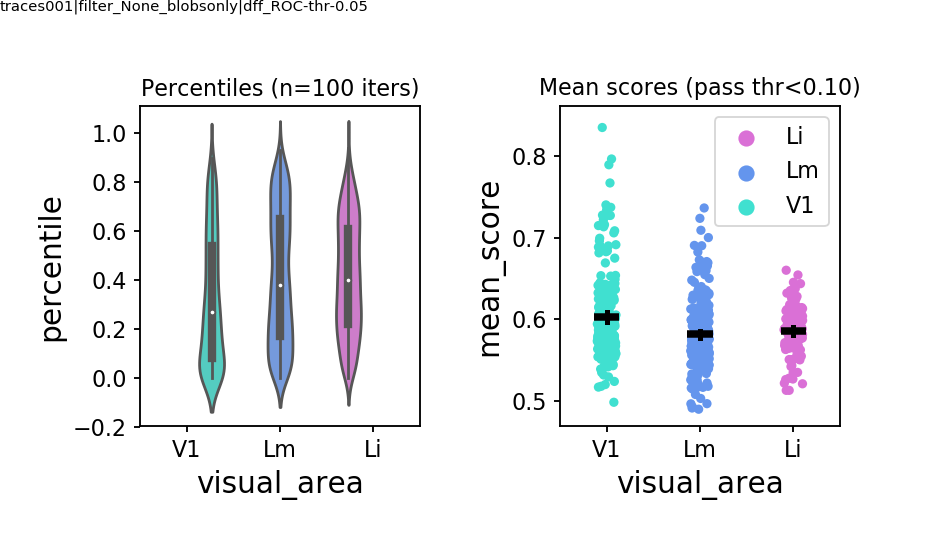

In [200]:
print(pass_perc.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']])

fig, axn = pl.subplots(1,2, figsize=(7, 4))
percentiles['percentile']= percentiles['percentile'].astype(float)

ax=axn[0]
ax.set_title('Percentiles (n=%i iters)' % n_iterations)
sns.violinplot(x='visual_area', y='percentile', data=percentiles, ax=ax,
              hue='visual_area', palette=area_colors, order=visual_areas)
ax.legend_.remove()

ax=axn[1]
ax.set_title('Mean scores (pass thr<%.2f)' % p_thr) # % n_iterations)
sns.stripplot(x='visual_area', y='mean_score', data=pass_perc, ax=ax,
              hue='visual_area', palette=area_colors, order=visual_areas, zorder=-1)
sns.pointplot(x='visual_area', y='mean_score', data=pass_perc, ax=ax,
              color='k', order=visual_areas, markers='_', scale=2, join=False, zorder=-1)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1., 1), loc='left')

pl.subplots_adjust(wspace=0.5, left=0.15, bottom=0.2, right=0.9, top=0.8)
putils.label_figure(fig, data_id)



In [201]:
percentiles.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]

,visual_area,cell
0,Li,1240
1,Lm,1830
2,V1,810


In [202]:
min_ncells=10
curr_dkeys = counts_by_fov[counts_by_fov['cell']>=min_ncells]['datakey'].unique()
all_dkeys = counts_by_fov['datakey'].unique()
print("%i of %i dkeys pass (min_ncells=%i)" % (len(curr_dkeys), len(all_dkeys), min_ncells))

22 of 39 dkeys pass (min_ncells=10)


In [203]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells'

In [204]:
itermean.head()

,visual_area,datakey,cell,condition,train_transform,test_transform,C,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,randi,iteration,n_cells,global_ix
0,Li,20190314_JC070_fov1,174,data,10_20_30_40,50,10.78246,0.003335,-0.007629,0.004811,0.531000,30.0,30.0,60.0,True,4786.03,2.0,1.0,0.0
1,Li,20190314_JC070_fov1,174,data,10_20_30_40,10_20_30_40,10.78246,0.012883,0.003059,0.018586,0.551042,120.0,120.0,240.0,False,4786.03,0.0,1.0,0.0
2,Li,20190314_JC070_fov1,174,data,10_20_30_50,40,11.58058,0.010057,0.002130,0.014509,0.555667,30.0,30.0,60.0,True,4521.56,5.0,1.0,0.0
3,Li,20190314_JC070_fov1,174,data,10_20_30_50,10_20_30_50,11.58058,0.011501,0.001001,0.016592,0.537708,120.0,120.0,240.0,False,4521.56,3.0,1.0,0.0
4,Li,20190314_JC070_fov1,174,data,10_20_40_50,30,1.86130,0.008339,-0.000337,0.012030,0.560333,30.0,30.0,60.0,True,4977.34,8.0,1.0,0.0


<IPython.core.display.Javascript object>


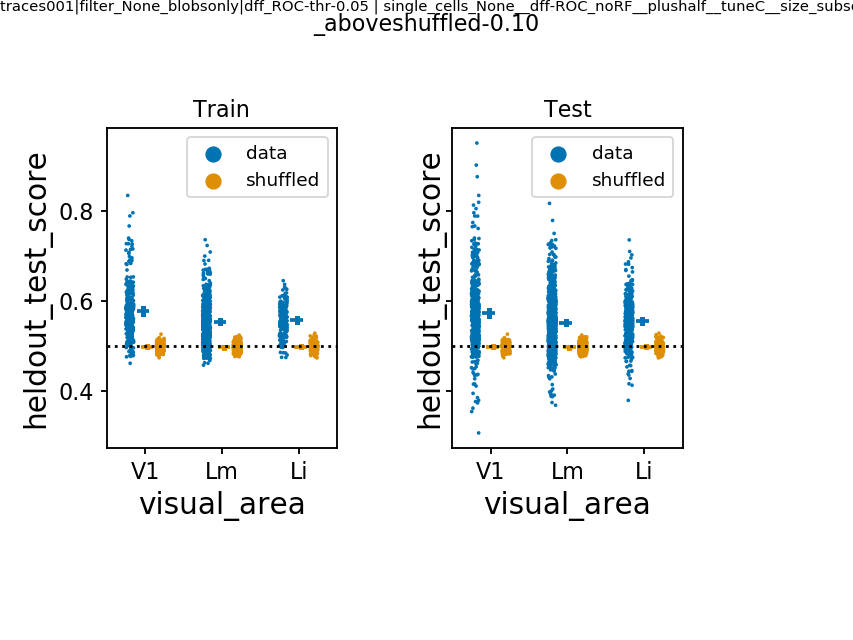

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_data-v-shuffled__aboveshuffled-0.10')


In [205]:
xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]
#meandf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

fig, axn = pl.subplots(1, 2, sharey=True)
ax=axn[0]
metric='test_score' if test_type is None else 'heldout_test_score'
d_ = xdf.copy() if test_type is None else xdf[~xdf.novel]
ax.set_title('Train')
sns.stripplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


ax=axn[1]
metric='heldout_test_score'
d_ = xdf.copy() #if test_type is None else xdf[xdf.novel]
ax.set_title('Test')
sns.stripplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle(pass_str)


figname = 'test_score__%s_data-v-shuffled_%s' % ( responsive_test, pass_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [87]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [206]:
xdf['visual_area'].unique()

array([u'Li', u'Lm', u'V1'], dtype=object)

In [207]:
area_colors

{'Li': 'orchid', 'Lm': 'cornflowerblue', 'V1': 'turquoise'}

In [208]:
passdf['visual_area'].unique()

array([u'Li', u'Lm', u'V1'], dtype=object)

In [209]:
if test_type is None:
    curr_metric = 'test_score'
    xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(singledf['datakey'].isin(ign))]

    fig, axn = pl.subplots(1, 2, sharey=True, figsize=(7,4))
    ax=axn[0]
    metric='test_score' #curr_metric
    ax.set_title(metric)

    ax = stripplot_by_area(metric, xdf[xdf['condition']=='data'], ax=ax, visual_areas=visual_areas, 
                           area_colors=area_colors, 
                           size=2, bar=True, annotate=True, xytext=(0,50))
    ax = stripplot_by_area(metric, xdf[xdf['condition']=='shuffled'], ax=ax, visual_areas=visual_areas, 
                           area_colors=area_colors, 
                           size=2, bar=False, annotate=False)

    #### Label
    if 'test_score' in metric:
        #ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, color='k', ls=':')
    ax.legend_.remove()


    ax=axn[1]
    metric='heldout_%s' % curr_metric
    ax.set_title(metric)
    ax = stripplot_by_area(metric, xdf[xdf['condition']=='data'], ax=ax, visual_areas=visual_areas, 
                           area_colors=area_colors, size=2, bar=True, annotate=True, xytext=(0,50))

    #ax.legend(bbox_to_anchor=(1.2, 1))
    if 'test_score' in metric:
        #ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, color='k', ls=':')

    aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1.2, 1))

    putils.label_figure(fig, '%s | %s' % (data_id, results_id))
    pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
    pl.suptitle(pass_str)

    figname = 'test_score__%s_by_fov_%s' % (responsive_test, pass_str)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

    print(dst_dir, figname)

In [210]:
xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]
xdf.head()

,visual_area,datakey,cell,condition,train_transform,test_transform,C,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,randi,iteration,n_cells,global_ix
15,Li,20190315_JC070_fov1,113,data,10_20_30_40,50,0.81937,0.035767,0.039466,0.051601,0.617167,30.0,30.0,60.0,True,5180.38,2.0,1.0,7.0
16,Li,20190315_JC070_fov1,113,data,10_20_30_40,10_20_30_40,0.81937,0.014335,0.004996,0.020681,0.550208,120.0,120.0,240.0,False,5180.38,0.0,1.0,7.0
17,Li,20190315_JC070_fov1,113,data,10_20_30_50,40,23.06350,0.000800,-0.011357,0.001154,0.493500,30.0,30.0,60.0,True,5200.53,5.0,1.0,7.0
18,Li,20190315_JC070_fov1,113,data,10_20_30_50,10_20_30_50,23.06350,0.023395,0.018473,0.033752,0.586042,120.0,120.0,240.0,False,5200.53,3.0,1.0,7.0
19,Li,20190315_JC070_fov1,113,data,10_20_40_50,30,3.17224,0.005329,-0.004737,0.007689,0.547833,30.0,30.0,60.0,True,4833.05,8.0,1.0,7.0


In [211]:
meanscores_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

<IPython.core.display.Javascript object>


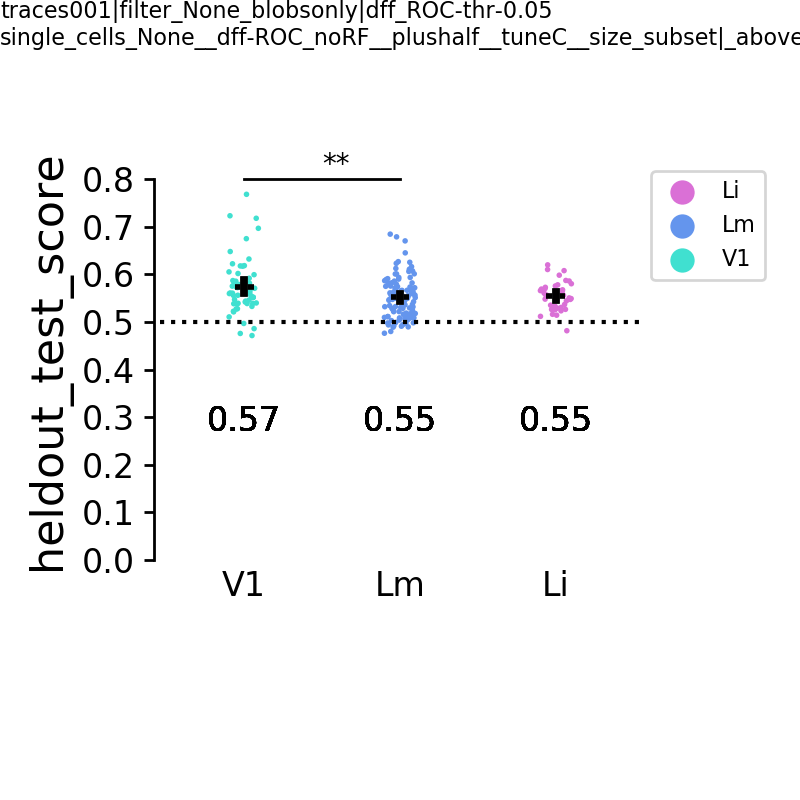

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.009 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.056 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.168 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_by_fov__aboveshuffled-0.10')


In [225]:
fig, ax = pl.subplots( sharey=True, figsize=(4,4), dpi=dpi)

metric='heldout_test_score'
multi_comp_test='fdr_bh'
y_loc=0.8
offset=0.1

ax = stripplot_by_area(metric, meanscores_by_cell[meanscores_by_cell['condition']=='data'], 
                       ax=ax, visual_areas=visual_areas, 
                       area_colors=area_colors, size=2, bar=True, annotate=True, xytext=(0,50))
statresults, ax = aggr.plot_mannwhitney(meanscores_by_cell[meanscores_by_cell['condition']=='data'], 
                                    metric=metric, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
if 'test_score' in metric:
    #ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')
    
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1., 1), loc='upper left', fontsize=8)

sns.despine(offset=2, trim=True, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

putils.label_figure(fig, '%s\n%s|%s' % (data_id, results_id, pass_str))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8, left=0.2)


figname = 'test_score__%s_by_fov_%s' % (responsive_test, pass_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

#### Compare scores by FOV

In [156]:
excl = ['20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190314_JC070_fov1',
        '20190327_JC073_fov1', '20191018_JC113_fov1', '20191111_JC120_fov1', '20190327_JC073_fov1']
for x in sorted(excl):
    print(x)

20190314_JC070_fov1
20190319_JC067_fov1
20190320_JC067_fov1
20190321_JC070_fov1
20190327_JC073_fov1
20190327_JC073_fov1
20191018_JC113_fov1
20191111_JC120_fov1


In [157]:
# excl=[]
counts_by_fov = xdf[xdf['condition']=='data'].groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
min_ncells=10
counts_by_fov[counts_by_fov['cell']<min_ncells]

,visual_area,datakey,cell


Lm    12
V1     8
Li     2
Name: visual_area, dtype: int64


<IPython.core.display.Javascript object>


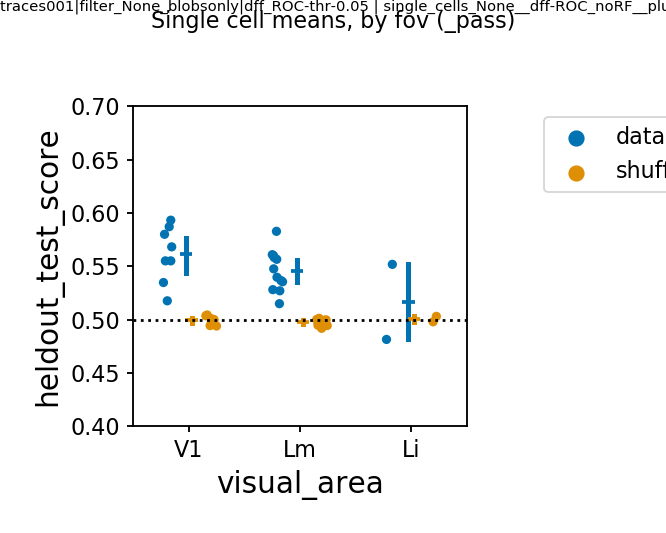

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.174 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.174 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.206 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_by_fov__pass')


In [158]:
metric = 'heldout_test_score'
#metric = 'test_score'
multi_comp_test='fdr_bh'


means_by_fov = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
df_ = means_by_fov[~means_by_fov['datakey'].isin(excl)]

print(df_[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())
      
fig, ax = pl.subplots( sharey=True, figsize=(5,4))
sns.stripplot(x='visual_area',  y=metric, data=df_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=5, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=df_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


#### Stats
statsresults, ax = aggr.plot_mannwhitney(df_[df_['condition']=='data'], 
                            metric=metric, multi_comp_test=multi_comp_test, 
                            ax=ax, y_loc=0.6, offset=0.01)
ax.set_ylim([0.4, 0.7])
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1.2, 1))


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle('Single cell means, by fov (%s)' % pass_str)
pl.subplots_adjust(left=0.2, top=0.8, bottom=0.2, right=0.7)


figname = 'test_score__%s_by_fov_%s' % (responsive_test, pass_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [357]:
means_by_fov[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts() #count()

V1    9
Lm    3
Li    2
Name: visual_area, dtype: int64

In [159]:

means_by_fov.groupby(['condition', 'visual_area']).mean()

cell          C  heldout_MI  heldout_aMI  \
condition visual_area                                                   
data      Li            85.777778   8.899043    0.014056     0.008194   
          Lm            73.483154   8.006116    0.020053     0.016033   
          V1           108.138145   9.144225    0.026250     0.024551   
shuffled  Li            85.777778  13.261797    0.009760     0.000032   
          Lm            73.483154   9.148248    0.009348    -0.000026   
          V1           108.138145   9.032369    0.009619     0.000019   

                       heldout_log2MI  heldout_test_score  n_samples_0  \
condition visual_area                                                    
data      Li                 0.020279            0.518519   100.000000   
          Lm                 0.028930            0.547828    79.476923   
          V1                 0.037870            0.561434    73.200000   
shuffled  Li                 0.014081            0.500666   160.000000   
          Lm                 0.013486            0.498006   127.076923   
          V1                 0.013877            0.499627   117.000000   

                       n_samples_106    n_trials  novel        randi  \
condition visual_area                                                  
data      Li              100.000000  200.000000    0.5  5016.866528   
          Lm               79.484615  158.961538    0.5  4995.886810   
          V1               73.187500  146.387500    0.5  5022.029011   
shuffled  Li              160.000000  320.000000    0.0  5016.866528   
          Lm              127.076923  254.153846    0.0  4995.886810   
          V1              117.000000  234.000000    0.0  5022.029011   

                       iteration  n_cells   global_ix  
condition visual_area                                  
data      Li                 7.0      1.0  164.569444  
          Lm                 7.0      1.0  429.038694  
          V1                 7.0      1.0  257.896701  
shuffled  Li                 7.0      1.0  164.569444  
          Lm                 7.0      1.0  429.038694  
          V1                 7.0      1.0  257.896701

In [160]:
groupdf[groupdf['visual_area']=='Li']['datakey'].unique()

NameError: name 'groupdf' is not defined

In [360]:
means_by_fov[means_by_fov['visual_area']=='Li']['datakey'].unique()

array(['20190602_JC091_fov1', '20190607_JC091_fov1'], dtype=object)

In [75]:
# fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y=metric, data=xdf, 
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
# sns.swarmplot(x='visual_area', y=metric, data=xdf, ax=ax,
#              palette=area_colors,  order=visual_areas,)

# xdf.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


<IPython.core.display.Javascript object>


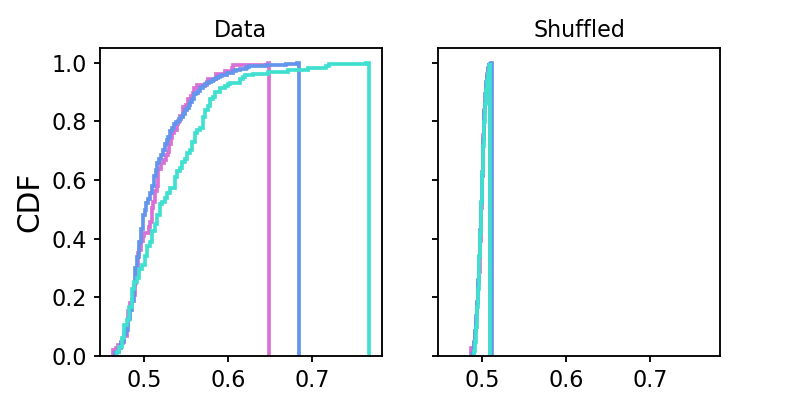

Text(0.5,1,u'Shuffled')

In [161]:
metric='heldout_test_score'
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)

ax=axn[0]
xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


for visual_area, vdf in means_by_cell[means_by_cell['condition']=='data'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
ax.set_title('Data')
ax.set_ylabel('CDF')
ax.set_xlabel('Accuracy')

ax=axn[1]
for visual_area, vdf in means_by_cell[means_by_cell['condition']=='shuffled'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True, lw=2, bins=100)
ax.set_title('Shuffled')

<IPython.core.display.Javascript object>


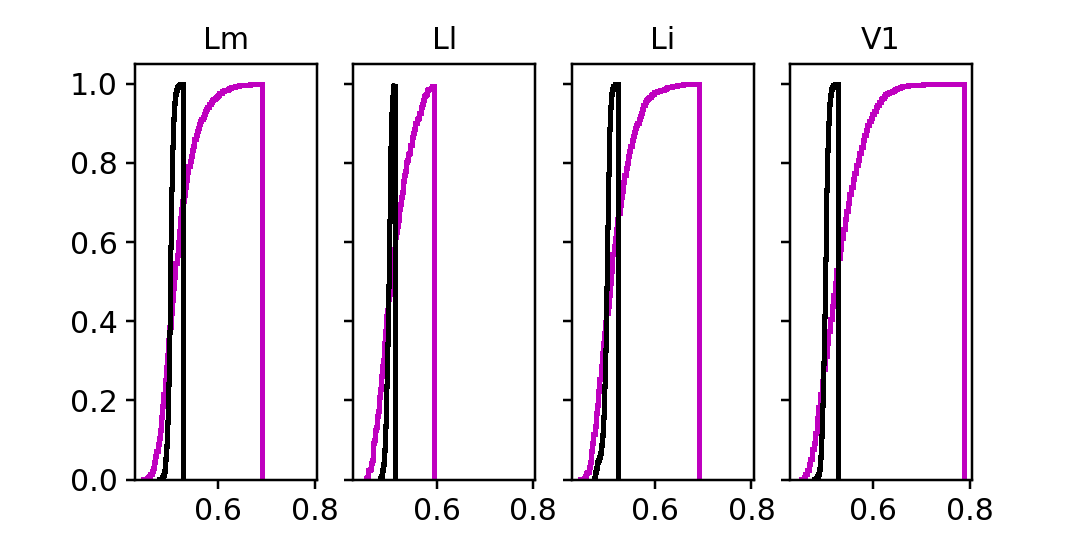

(u'Li', Ks_2sampResult(statistic=0.4716821639898563, pvalue=6.634645922201448e-116))
(u'Ll', Ks_2sampResult(statistic=0.4339080459770115, pvalue=1.948110918915034e-29))
(u'Lm', Ks_2sampResult(statistic=0.4589347934295669, pvalue=1.2588836229409475e-185))
(u'V1', Ks_2sampResult(statistic=0.5853458862054851, pvalue=0.0))


In [46]:
xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


fig, axn = pl.subplots(1,4, figsize=(6,3), sharex=True, sharey=True)
for ai, (visual_area, vdf) in enumerate(means_by_cell.groupby(['visual_area'])):
    ax=axn[2-ai]
    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    
    print("%s" % visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))
    
    n, bins, patches = ax.hist(d1[metric].values, color='m',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    n, bins, patches = ax.hist(d2[metric].values, color='k',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    
    ax.set_title(visual_area)
    

In [101]:
for visual_area in visual_areas:
    vdf = means_by_cell[means_by_cell['visual_area']==visual_area]

    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    

    print(visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))

('V1', Ks_2sampResult(statistic=0.6029106029106028, pvalue=1.3842212387758096e-306))
('Lm', Ks_2sampResult(statistic=0.451198129748685, pvalue=5.527543340959283e-153))
('Li', Ks_2sampResult(statistic=0.4696707105719238, pvalue=3.9504799758792587e-112))
('Ll', Ks_2sampResult(statistic=0.438953488372093, pvalue=8.887476305385559e-30))


# Tests

<IPython.core.display.Javascript object>


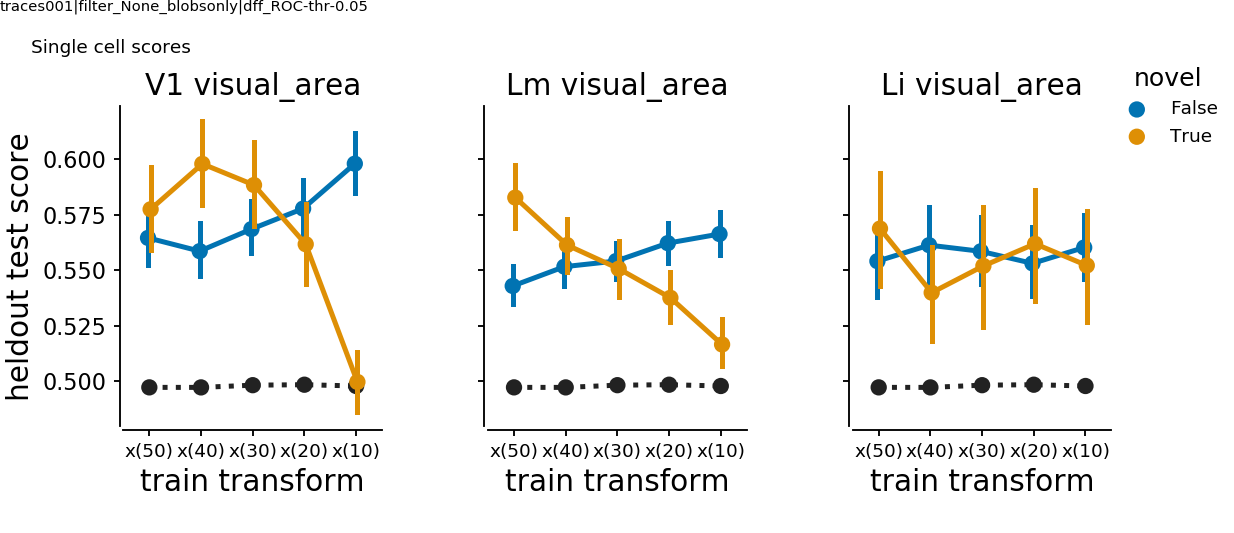

Text(0.025,0.9,u'Single cell scores')

In [162]:

metric_label='heldout test score'
mdf = passdf.groupby(['visual_area', 'datakey', 'cell', 'condition', 'train_transform', 'test_transform']).mean().reset_index()


g = sns.catplot(x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='data'], 
            hue='novel', palette='colorblind', dodge=True, kind='point', 
            col='visual_area', col_order=visual_areas, height=4, aspect=0.7, legend_out=True)

g.map(sns.pointplot, x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='shuffled'],
      hue='novel', linestyles=':', legend_out=True)

(g.set_axis_labels("train transform", metric_label)\
     .set_titles("{col_name} {col_var}")\
     .despine(offset=2)\
#      .set(ylim=(0.4, 0.6))\
     .set_xticklabels(train_labels, fontsize=10))

pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.9)
g._legend.set(bbox_to_anchor=(1., 0.8))

putils.label_figure(g.fig, data_id)
g.fig.text(0.025, 0.9, 'Single cell scores')
